In [19]:
'''
Qiskit - PennyLane code for testing fidelity of randomised and derandomised classical shadows on the ground state energy of H2

For the randomized classical shadow: 
1. Choose an ansatz and run VQE using the Hamiltonian obtained from PySCFDriver in Qiskit. 
   VQE minimizes the expectation value of the Hamiltonian to obtain the ground state energy (-> minimal eigenvalue)
   Output: set of angles for the ansatz corresponding to the found ground state energy approximation
2. Calculate the size N of the shadow (= number of measurements, each measurement may use the same or different observable)
3. Generate N random Pauli operators U. 
   These N operators correspond to the number of measurements as the operators may repeat. 
4. Apply the random Pauli operators U to the ansatz with optimal angles (without the Hamiltonian).
   Store the measurement outputs in classical memory. (==> shadow)
5. Use the stored shadow to reconstruct the state:
   Input: the Hamiltonian obtained from PySCFDriver as observables, the shadow obtained in 4

For the derandomized classical shadow:
1. Input: The original Bravyi-Kitaev encoded Hamiltonian (it will be derandomized) 
2. Apply the derandomized Pauli operators U to the ansatz with optimal angles as measurements.
   Store the measurement outputs in classical memory. (==> derand_shadow)
3. Use the stored shadow to reconstruct the state:
   Input: the original BK-encoded Hamiltonian obtained from PySCFDriver as observables, measurements from step 2 as measurements.
'''


from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

'''
# BeH2

driver = PySCFDriver(
    atom="Be 0 0 0; H 0 0 1.3264; H 0 0 -1.3264",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)
'''

problem = driver.run()

hamiltonian = problem.hamiltonian
#coefficients = hamiltonian.electronic_integrals

# The electronic Hamiltonian of the system
second_q_op = hamiltonian.second_q_op()

# Solving the electronic structure problem = determine the ground state energy of the molecule
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

# The Bravyi-Kitaev repserentation of the Fermionic Hamiltonian
mapper = BravyiKitaevMapper()
bkenc_hamiltonian = mapper.map(second_q_op)

print(bkenc_hamiltonian)

-0.8105479805373234 * IIII
+ 0.1721839326191557 * IIIZ
- 0.2257534922240249 * IIZZ
+ 0.1721839326191554 * IZII
- 0.22575349222402488 * ZZZI
+ 0.1209126326177664 * IIZI
+ 0.1689275387008791 * IZIZ
+ 0.04523279994605785 * ZXIX
- 0.04523279994605785 * IXZX
- 0.04523279994605785 * ZXZX
+ 0.04523279994605785 * IXIX
+ 0.1661454325638242 * ZZZZ
+ 0.16614543256382422 * IZZZ
+ 0.1746434306830045 * ZZIZ
+ 0.1209126326177664 * ZIZI


In [20]:
#Get the weights for the BK-encoded Hamiltonian
# Warning: the order of terms in the Hamiltonian can change slightly in each run!

hamiltonian_terms = []
weights = []

for observable in bkenc_hamiltonian:
    
    observable_str = str(observable)
    observable_str_clean = observable_str.strip()  # removes white spaces
    pauli_str_list = observable_str_clean.split('*')
    tuple_list = []
    
    for op_index, pauli_op in enumerate(pauli_str_list[1]):
        if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
            tuple_list.append((pauli_op, op_index-1))
    if len(tuple_list) > 0:
        hamiltonian_terms.append(tuple_list)
        weights.append(float(pauli_str_list[0].strip()))

print(hamiltonian_terms)
print(weights)

[[('I', 0), ('I', 1), ('I', 2), ('I', 3)], [('I', 0), ('I', 1), ('I', 2), ('Z', 3)], [('I', 0), ('I', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('Z', 1), ('I', 2), ('I', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('I', 3)], [('I', 0), ('I', 1), ('Z', 2), ('I', 3)], [('I', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('X', 1), ('I', 2), ('X', 3)], [('I', 0), ('X', 1), ('Z', 2), ('X', 3)], [('Z', 0), ('X', 1), ('Z', 2), ('X', 3)], [('I', 0), ('X', 1), ('I', 2), ('X', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('Z', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('I', 1), ('Z', 2), ('I', 3)]]
[-0.8105479805373234, 0.1721839326191557, -0.2257534922240249, 0.1721839326191554, -0.22575349222402488, 0.1209126326177664, 0.1689275387008791, 0.04523279994605785, -0.04523279994605785, -0.04523279994605785, 0.04523279994605785, 0.1661454325638242, 0.16614543256382422, 0.1746434306830045, 0.1209126326177664]


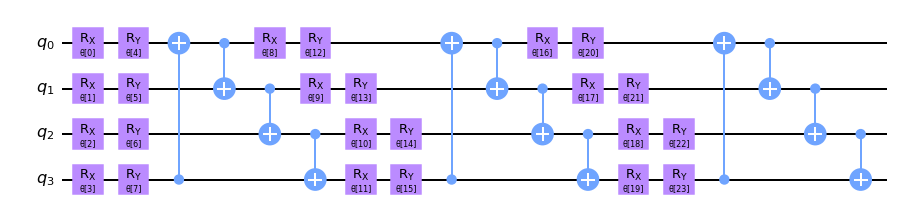

In [21]:
# Hardware-efficient ansatz
from qiskit.circuit.library import TwoLocal, EfficientSU2

#ansatz = TwoLocal(num_qubits=system_size, reps=10, rotation_blocks=['ry','rz'],
#                entanglement_blocks='cz', skip_final_rotation_layer=True)

reps = 3     # this value is later used in the PennyLane translation of the ansatz. 1-2 layers not enough for H2
ansatz = EfficientSU2(4, su2_gates=['rx', 'ry'], entanglement='circular', reps=reps, skip_final_rotation_layer=True)

ansatz.decompose().draw('mpl')

In [22]:
# Classical minimum eigensolver

from qiskit_nature.second_q.mappers import BravyiKitaevMapper, QubitConverter
converter = QubitConverter(BravyiKitaevMapper())

# CLASSICAL solver to verify our vqe results
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
numpy_solver = NumPyMinimumEigensolver()   

# Optimisation process for the classical solver
calc = GroundStateEigensolver(converter, numpy_solver)
res = calc.solve(problem)
print('Optimization using classical minimum eigensolver:\n', res) 

Optimization using classical minimum eigensolver:
 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [23]:
# Running VQE on the Hamiltonian obtained from PySCFDriver using Statevector simulator (Estimator primitive)
# NOTE: VQE performs sometimes much worse than VQEUCCFactory

# QUANTUM with REGULAR HAMILTONIAN 
from qiskit.algorithms.optimizers import SLSQP

# Estimator primitive is based on the Statevector construct = algebraic simulation
from qiskit.primitives import Estimator    

from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit_nature.second_q.circuit.library import UCCSD
estimator = Estimator()
# If shots = None, it calculates the exact expectation values. Otherwise, it samples from normal distributions 
# with standard errors as standard deviations using normal distribution approximation.
estimator.set_options(shots = None)
#vqe_solver = VQEUCCFactory(Estimator(), UCCSD(), SLSQP(maxiter=20))
vqe_solver = VQE(estimator, ansatz, SLSQP(maxiter=15000))

# Optimisation
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
calc = GroundStateEigensolver(converter, vqe_solver)
result = calc.solve(problem)
print('Optimization using VQE solver with the regular Hamiltonian:\n', result)
print(result.raw_result)

Optimization using VQE solver with the regular Hamiltonian:
 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857270591968
  - computed part:      -1.857270591968
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137301597519
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38897153]
    - computed part:      [0.0  0.0  1.38897153]
  > Dipole moment (a.u.): [0.0  0.0  -0.00002283]  Total: 0.00002283
                 (debye): [0.0  0.0  -0.00005803]  Total: 0.00005803
 
{   'aux_operators_evaluated': {   'AngularMomentum': (   4.070603542877249e-06,
                                                          {}),
                                   'Magnetization': (   1.8949670196888313e-06,
                                                    

In [24]:
parameter_values = result.raw_result.optimal_point
print(parameter_values)                            # optimal angles for the ansatz
expected_value = result.raw_result.optimal_value
print(expected_value)     

[ 1.58555350e+00 -6.94902337e-03 -3.13898635e+00  2.01329372e-01
 -1.96579102e+00  1.57114712e+00  1.57089238e+00 -1.57050937e+00
  3.12720457e+00  1.52646072e+00 -2.97319878e+00  1.51386105e-01
  1.36966692e+00  1.79454350e+00 -1.56652740e+00  1.57006324e+00
  3.14159265e+00  3.14159265e+00  1.58475496e+00 -3.13766396e+00
 -7.33948124e-03 -3.02595775e-03  2.96314525e-03  3.14159265e+00]
-1.8572705919676658


In [7]:
# Running VQE on the Hamiltonian obtained form PySCFDriver using qasm simulator (Estimator in Qiskit Runtime)
# NOTE: Results with the ansatz are very bad. UCCSD performs much better! 
# Recommend to use the above Estimator primitive instead.

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from qiskit_nature.second_q.mappers import BravyiKitaevMapper, QubitConverter
converter = QubitConverter(BravyiKitaevMapper())

from qiskit.algorithms.optimizers import SLSQP
  
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

from qiskit_ibm_runtime import Options
options = Options()
options.resilience_level = 1  #(1 = readout error mitigation)
options.execution.shots = 2000

estimator = Estimator(session=backend, options=options)

from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit_nature.second_q.circuit.library import UCCSD
#vqe_solver = VQEUCCFactory(Estimator(), UCCSD(), SLSQP(maxiter=3000))
vqe_solver = VQE(Estimator(), ansatz, SLSQP(maxiter=10000))

# optimisation process for vqe with the standard Hamiltonian
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
calc = GroundStateEigensolver(converter, vqe_solver)
result = calc.solve(problem)
print('Optimization with VQE solver using the regular Hamiltonian:\n', result)

# Set of optimal angles for the ansatz that produces the best approximation to the ground state energy
print(result.raw_result)

/home/renata/.local/lib/python3.8/site-packages/urllib3/connection.py:382: SystemTimeWarning: System time is way off (before 2022-01-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/renata/.local/lib/python3.8/site-packages/urllib3/connection.py:382: SystemTimeWarning: System time is way off (before 2022-01-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/renata/.local/lib/python3.8/site-packages/urllib3/connection.py:382: SystemTimeWarning: System time is way off (before 2022-01-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/renata/.local/lib/python3.8/site-packages/urllib3/connection.py:382: SystemTimeWarning: System time is way off (before 2022-01-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/renata/.local/lib/python3.8/site-packages/urllib3/connection.py:382: SystemTimeWarning: System time is way off (before 2022-01-01). This will probably lead to SSL verific

Optimization with VQE solver using the regular Hamiltonian:
 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -0.805928229539
  - computed part:      -0.805928229539
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -0.08595923509
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.046 S: 0.553 S^2: 0.858 M: -0.007
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.27287056]
    - computed part:      [0.0  0.0  1.27287056]
  > Dipole moment (a.u.): [0.0  0.0  0.11607814]  Total: 0.11607814
                 (debye): [0.0  0.0  0.29504118]  Total: 0.29504118
 
{   'aux_operators_evaluated': {   'AngularMomentum': (   0.8580625000000001,
                                                          {   'readout_mitigation_num_twirled_circuits': 16,
                                                              'readout_mitigation_shots_cal

In [8]:
parameter_values = result.raw_result.optimal_point
print(parameter_values)
expected_value = result.raw_result.optimal_value
print(expected_value)

[ 1.58713245  1.43056169 -0.41913423 -0.33532624  2.43378152  2.01486053
  0.90837103 -2.76711905 -0.6252002  -0.37654252  2.25912263  1.992283
  1.81189854  2.9211203   3.0803289  -0.6680448   2.96368543  1.13473035
  2.1868921  -1.99944085  1.45913184  2.00938738  1.80010811 -2.34855633]
-0.8059282295387158


In [25]:
# Calculate the required number of classical shadows 
# adapted for Qiskit from official Pennylane code

import numpy as np

def shadow_bound(error, observables, failure_rate=0.01):
    """
    Calculate the shadow bound for the Pauli measurement scheme.

    Implements Eq. (S13) from https://arxiv.org/pdf/2002.08953.pdf

    Args:
        error (float): The error on the estimator.
        observables (list) : List of matrices corresponding to the observables we intend to
            measure.
        failure_rate (float): Rate of failure for the bound to hold.

    Returns:
        An integer that gives the number of samples required to satisfy the shadow bound and
        the chunk size required attaining the specified failure rate.
    """
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(o) for o in observables) / error ** 2
    #print('N', N)
    #print(max(shadow_norm(o) for o in observables))
    return int(np.ceil(N * K)), int(K)

num_measurements, k = shadow_bound(error=2e-1, observables=[observable.to_matrix().real for observable in bkenc_hamiltonian])
print('Number of measurements N:', num_measurements)  

Number of measurements N: 2011984


In [26]:
# BeH2 requires 14 qubits (see also Flammia's paper)
#system_size = 14 # without core freeze and orbital removal. with core freeze system_size = 12. orbital removal not recommended.

system_size = 4                 # for H2


num_measurements = 1000   # setting manually instead of the required number since processing time unknown for 2 million (> 5h).



In [27]:
# Since Qiskit does not support extraction of expectation values on single qubits, we utilize PennyLane for that purpose.
# This involves:
# Translate the Qiskit ansatz into PennyLane
# Using another random set of unitaries instead of the one generated using Hsin-Yuan Huang's original code.

import pennylane as qml

dev = qml.device("default.qubit", wires=system_size, shots=1)

@qml.qnode(dev)
def ansatz(params, reps, observable):
    
    for iter in range(reps):
        for w in range(system_size):
            qml.RX(params[w + 2*iter*system_size], wires=w)
        for w in range(system_size):
            qml.RY(params[w + system_size + 2*iter*system_size], wires=w)

        qml.CNOT(wires=[system_size - 1, 0])
        for w in range(system_size - 1):
            qml.CNOT(wires=[w, w+1])
    
    return [qml.expval(o) for o in observable]     


# Calculate classical shadow based on the generated N random unitaries and ansatz with ground state energy angles
# Method from PennyLane

#from qiskit_aer import QasmSimulator
#backend = QasmSimulator(method='statevector')

def calculate_classical_shadow(ansatz, reps, params, shadow_size, num_qubits):
    """
    Given a circuit, creates a collection of snapshots consisting of a bit string
    and the index of a unitary operation.

    Args:
        circuit_template (function): A Pennylane QNode.
        params (array): Circuit parameters.
        shadow_size (int): The number of snapshots in the shadow. (N)
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        Tuple of two numpy arrays. The first array contains measurement outcomes (-1, 1)
        while the second array contains the index for the sampled Pauli's (0,1,2=X,Y,Z).
        Each row of the arrays corresponds to a distinct snapshot or sample while each
        column corresponds to a different qubit.
    """
    # sample random Pauli measurements uniformly, where 0,1,2 = X,Y,Z
    # applying the single-qubit Clifford circuit is equivalent to measuring a Pauli
    unitary_ensemble = [qml.PauliX, qml.PauliY, qml.PauliZ]

    # sample random Pauli measurements uniformly, where 0,1,2 = X,Y,Z
    unitary_ids = np.random.randint(0, 3, size=(shadow_size, num_qubits))
    outcomes = np.zeros((shadow_size, num_qubits))
    for ns in range(shadow_size):
        # for each snapshot, add a random Pauli observable at each location
        obs = [unitary_ensemble[int(unitary_ids[ns, i])](i) for i in range(num_qubits)]
        outcomes[ns, :] = ansatz(params, reps, observable=obs)
    
    # combine the computational basis outcomes and the sampled unitaries
    return (outcomes, unitary_ids)

    '''
    unitary_ids = []#np.zeros((shadow_size, num_qubits))
    outcomes = np.zeros((shadow_size, num_qubits))
    for index, measurement in enumerate(measurements):
        obs = []
        for ind, pauli in enumerate(measurement):
            if pauli == 'X':
                obs.insert(ind, 0)
            if pauli == 'Y':
                obs.insert(ind, 1) 
            if pauli == 'Z':
                obs.insert(ind, 2)
            #outcome[ind] = optimal_ansatz()
        # for each snapshot, add a random Pauli observable at each location
        unitary_ids.append(obs)
        
        outcomes[index, :] = ansatz(params, observable=obs)
        '''
    
num_qubits = system_size
shadow = calculate_classical_shadow(ansatz, reps, parameter_values, num_measurements, num_qubits)
#print(shadow[0])   # eigenvalues
#print(shadow[1])   # unitaries   

In [28]:
# Reconstructing states from shadows: helper functions
def snapshot_state(b_list, obs_list):
    """
    Helper function for `shadow_state_reconstruction` that reconstructs
     a state from a single snapshot in a shadow.

    Implements Eq. (S44) from https://arxiv.org/pdf/2002.08953.pdf

    Args:
        b_list (array): The list of classical outcomes for the snapshot.  # row of the first matrix
        obs_list (array): Indices for the applied Pauli measurement.      # row of the second matrix

    Returns:
        Numpy array with the reconstructed snapshot.
    """

    num_qubits = len(b_list)

    # computational basis states
    zero_state = np.array([[1, 0], [0, 0]])
    one_state = np.array([[0, 0], [0, 1]])

    # local qubit unitaries
    phase_z = np.array([[1, 0], [0, -1j]], dtype=complex)    # this is the SSS gate, or phase shift by -pi/2
    hadamard = qml.matrix(qml.Hadamard(0))
    identity = qml.matrix(qml.Identity(0))

    # undo the rotations that were added implicitly to the circuit for the Pauli measurements in the X, Y and Z basis
    unitaries = [hadamard, hadamard @ phase_z, identity]

    # reconstructing the snapshot state from local Pauli measurements
    rho_snapshot = [1]
    for i in range(num_qubits):
        state = zero_state if b_list[i] == 1 else one_state   # state = |0><0| for eigenvalue 1, |1><1| for eigenvalue -1
        U = unitaries[int(obs_list[i])]

        # applying Eq. (S44)
        local_rho = 3 * (U.conj().T @ state @ U) - identity
        rho_snapshot = np.kron(rho_snapshot, local_rho)    # kronecker product: mult each el in snapshot with each in local
        
    #print('local_rho\n', local_rho)
    #print('rho_snapshot\n', rho_snapshot)
    return rho_snapshot


def shadow_state_reconstruction(shadow):
    """
    Reconstruct a state approximation as an average over all snapshots in the shadow.

    Args:
        shadow (tuple): A shadow tuple obtained from `calculate_classical_shadow`.

    Returns:
        Numpy array with the reconstructed quantum state.
    """
    num_snapshots, num_qubits = shadow[0].shape

    # classical values
    b_lists, obs_lists = shadow

    # Averaging over snapshot states.
    shadow_rho = np.zeros((2 ** num_qubits, 2 ** num_qubits), dtype=complex)
    for i in range(num_snapshots):
        shadow_rho += snapshot_state(b_lists[i], obs_lists[i])

    return shadow_rho / num_snapshots



# CALCULATING EXPECTATION VALUES FROM CLASSICAL SHADOWS
def estimate_shadow_observable(shadow, observable, k=10):
    """
    Adapted from https://github.com/momohuang/predicting-quantum-properties
    Calculate the estimator E[O] = median(Tr{rho_{(k)} O}) where rho_(k)) is set of k
    snapshots in the shadow. Use median of means to ameliorate the effects of outliers.

    Args:
        shadow (tuple): A shadow tuple obtained from `calculate_classical_shadow`.
        observable (qml.Observable): Single PennyLane observable consisting of single Pauli
            operators e.g. qml.PauliX(0) @ qml.PauliY(1).
        k (int): number of splits in the median of means estimator.

    Returns:
        Scalar corresponding to the estimate of the observable.
    """
    shadow_size, num_qubits = shadow[0].shape

    # convert Pennylane observables to indices
    map_name_to_int = {"PauliX": 0, "PauliY": 1, "PauliZ": 2}
    if isinstance(observable, (qml.PauliX, qml.PauliY, qml.PauliZ)):
        target_obs, target_locs = np.array(
            [map_name_to_int[observable.name]]
        ), np.array([observable.wires[0]])
    else:
        target_obs, target_locs = np.array(
            [map_name_to_int[o.name] for o in observable.obs]
        ), np.array([o.wires[0] for o in observable.obs])

    # classical values
    b_lists, obs_lists = shadow
    means = []

    # loop over the splits of the shadow:
    for i in range(0, shadow_size, shadow_size // k):

        # assign the splits temporarily
        b_lists_k, obs_lists_k = (
            b_lists[i : i + shadow_size // k],
            obs_lists[i : i + shadow_size // k],
        )

        # find the exact matches for the observable of interest at the specified locations
        indices = np.all(obs_lists_k[:, target_locs] == target_obs, axis=1)

        # catch the edge case where there is no match in the chunk
        if sum(indices) > 0:
            # take the product and sum
            product = np.prod(b_lists_k[indices][:, target_locs], axis=1)
            means.append(np.sum(product) / sum(indices))
        else:
            means.append(0)

    return np.median(means)

In [29]:
# Translate the original Hamiltonian into PennyLane

list_of_observables = (
    [qml.PauliZ(3)] 
    + [qml.PauliZ(2) @ qml.PauliZ(3)]
    + [qml.PauliZ(1)]
    + [qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2)]
    + [qml.PauliZ(2)]
    + [qml.PauliZ(1) @ qml.PauliZ(3)]
    + [qml.PauliZ(0) @ qml.PauliX(1) @ qml.PauliX(3)]
    + [qml.PauliX(1) @ qml.PauliZ(2) @ qml.PauliX(3)]
    + [qml.PauliZ(0) @ qml.PauliX(1) @ qml.PauliZ(2) @ qml.PauliX(3)]
    + [qml.PauliX(1) @ qml.PauliX(3)]
    + [qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3)]
    + [qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3)]
    + [qml.PauliZ(0) @ qml.PauliZ(1)  @ qml.PauliZ(3)]
    + [qml.PauliZ(0) @ qml.PauliZ(2)]
)


In [30]:
# We do 10 runs = generate 10 sets of random measurements.
# Then, we take the mean error for fidelity estimation:

shadows = []

num_experiments = 10




for i in range(num_experiments):
    shadow = calculate_classical_shadow(ansatz, reps, parameter_values, num_measurements, num_qubits)
    shadows.append(shadow)
    
    
minimal_eigenvalues = []

for shadow in shadows:
    estimates = [[1.0]]   # expectation value for the IIII observable in the Hamiltonian
    estimates.append([estimate_shadow_observable(shadow, o, k=k) for o in list_of_observables])
    estimates = sum(estimates, [])
    minimal_eigenvalue = np.dot(weights, estimates)
    minimal_eigenvalues.append(minimal_eigenvalue)
    print(f"The expected minimum eigenvalue of the Hamiltonian for H2: {minimal_eigenvalue}")
    
rmse_randomised_cs = []
for minimal_eigenvalue in minimal_eigenvalues:
    rmse_randomised_cs.append((expected_value - minimal_eigenvalue)**2)
rmse_randomised_cs = (sum(rmse_randomised_cs)) / len(shadows)
print(f"The average root-mean-squared error for randomised classical shadow on H2: {rmse_randomised_cs}")

The expected minimum eigenvalue of the Hamiltonian for H2: -0.14697273825793888
The expected minimum eigenvalue of the Hamiltonian for H2: -0.35978693267087036
The expected minimum eigenvalue of the Hamiltonian for H2: -0.35332510410714785
The expected minimum eigenvalue of the Hamiltonian for H2: -0.1871796715433236
The expected minimum eigenvalue of the Hamiltonian for H2: -0.18215380488265048
The expected minimum eigenvalue of the Hamiltonian for H2: -0.34829923744647473
The expected minimum eigenvalue of the Hamiltonian for H2: -0.35332510410714785
The expected minimum eigenvalue of the Hamiltonian for H2: -0.17210207156130433
The expected minimum eigenvalue of the Hamiltonian for H2: -0.3684027040891671
The expected minimum eigenvalue of the Hamiltonian for H2: -0.35332510410714785
The average root-mean-squared error for randomised classical shadow on H2: 2.4881867160980766


In [16]:




# BELOW: DERANDOMISED CLASSICAL SHADOW


 
    

In [31]:
# Translate the derandomized measurements into ids


def calculate_derand_classical_shadow(ansatz, reps, params, derandomized_measurements, num_qubits):
    
    unitary_ensemble = [qml.PauliX, qml.PauliY, qml.PauliZ]
    num_measurements = len(derandomized_measurements)

    unitary_id = []
    for measurement in derandomized_measurements:
        ids = []
        for index, observable in enumerate(measurement):
            if observable == 'X':
                ids.insert(index, 0)
            if observable == 'Y':
                ids.insert(index, 1)
            if observable == 'Z':
                ids.insert(index, 2)
        unitary_id.append(ids)
        
    unitary_ids = np.array([np.array(x) for x in unitary_id])
    
    outcomes = np.zeros((num_measurements, num_qubits))

    for ns in range(num_measurements):
        # for each snapshot, add a random Pauli observable at each location
        obs = [unitary_ensemble[int(unitary_ids[ns, i])](i) for i in range(num_qubits)]
        outcomes[ns, :] = ansatz(params, reps, observable=obs)
    
    # combine the computational basis outcomes and the sampled unitaries
    return (outcomes, unitary_ids)

    
    

#print(derand_shadow[0])   # eigenvalues
#print(derand_shadow[1])   # unitaries

In [40]:
'''
CORRECT VERSION (as I see it):

1. Derandomize the BK-encoded Hamiltonian using derandomized_classical_shadow > generated_observables.txt
2. Measure the ansatz with optimal angles as parameters and generated_observables.txt. 
   Store the emasurement results in measurement.txt
   (measurement.txt resembles a shadow, hence we call it derand_shadow)
3. Use prediction_shadow on measurement.txt and observables.txt to obtain expectation values.
   (prediciton_shadow corresponds to PennyLane's estimate_shadow_observable)
   (Question: what are observables.txt? Is it the original BK-encoded Hamiltonian?)

'''

from derand.data_acquisition_shadow import derandomized_classical_shadow

minimal_eigenvalues_derand = []
num_obs_evals = 6

for _ in range(num_experiments):

    # STEP 1
    generated_observables = derandomized_classical_shadow(hamiltonian_terms, num_obs_evals, system_size, weight=weights)

    # STEP 2
    derand_shadow = calculate_derand_classical_shadow(ansatz, reps, parameter_values, generated_observables, num_qubits)

    # STEP 3
    estimates = [[1.0]]   # expectation value for the IIII observable in the Hamiltonian
    estimates.append([estimate_shadow_observable(derand_shadow, o, k=k) for o in list_of_observables])
    estimates = sum(estimates, [])
    
    minimal_eigenvalue_derand = np.dot(weights, estimates)
    minimal_eigenvalues_derand.append(minimal_eigenvalue_derand)
    
    print(f"The expected minimum eigenvalue of the Hamiltonian for H2: {minimal_eigenvalue_derand}")

    
    
rmse_derandomised_cs = []
for minimal_eigenvalue_derand in minimal_eigenvalues_derand:
    rmse_derandomised_cs.append((expected_value - minimal_eigenvalue_derand)**2)
    
rmse_derandomised_cs = sum(rmse_derandomised_cs) / num_experiments
print(f"The average root-mean-squared error for randomised classical shadow on H2: {rmse_derandomised_cs}")

The expected minimum eigenvalue of the Hamiltonian for H2: -0.9827319131564788
The expected minimum eigenvalue of the Hamiltonian for H2: -0.9827319131564788
The expected minimum eigenvalue of the Hamiltonian for H2: -0.9827319131564788
The expected minimum eigenvalue of the Hamiltonian for H2: -0.9827319131564788
The expected minimum eigenvalue of the Hamiltonian for H2: -0.9827319131564788
The expected minimum eigenvalue of the Hamiltonian for H2: -0.9827319131564788
The expected minimum eigenvalue of the Hamiltonian for H2: -0.9827319131564788
The expected minimum eigenvalue of the Hamiltonian for H2: -0.9827319131564788
The expected minimum eigenvalue of the Hamiltonian for H2: -0.9827319131564788
The expected minimum eigenvalue of the Hamiltonian for H2: -0.9827319131564788
The average root-mean-squared error for randomised classical shadow on H2: 0.7648179007368164


In [ ]:
'''
Observation: 
the lower the number of evaluations per observable the lower the error. But then the generated mesurements are the same. 
At higher numbers of evals the generated measurements begin to differ and the exp_vals are different. But the error is higher.
'''